<a href="https://colab.research.google.com/github/goflvhxj/MLDL_practice/blob/main/object%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Image + bounding box 시각화**

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

In [ ]:
# 데이터셋 불러오기
img_knife_list = sorted(glob.glob('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/*'))
img_pistol_list = sorted(glob.glob('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/pistol/*'))
annot_knife_list = sorted(glob.glob('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/annotation/knife_xml/*'))
annot_pistol_list = sorted(glob.glob('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/annotation/pistol_xml/*'))

In [ ]:
print(len(img_knife_list))
print(len(img_pistol_list))
print(len(annot_knife_list))
print(len(annot_pistol_list))

2078
3000
2078
3000


In [ ]:
print(img_knife_list[:10])
print(annot_knife_list[:10])

['/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/DSC_0001.JPG', '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/DSC_00011.JPG', '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/DSC_0002.JPG', '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/DSC_00021.JPG', '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/DSC_0003.JPG', '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/DSC_00031.JPG', '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/DSC_0004.JPG', '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/DSC_00041.JPG', '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/DSC_0005.JPG', '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife/DSC_00051.JPG']
['/content/drive/MyDrive/2023 ICT 융합 프ᄅ

In [ ]:
# bounding box 좌표값 저장 후 반환
def generate_box(obj):
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)
  
  return [xmin, ymin, xmax, ymax]

# bounding box label 생성
def generate_label(obj):
  if obj.find('name').text == "knife":
      return 1
  return 0  # pistol인 경우

# generate_box 함수 실행
def generate_target(file): 
  with open(file) as f:
      data = f.read()
      soup = BeautifulSoup(data, "html.parser")
      objects = soup.find_all("object")

      num_objs = len(objects)

      boxes = []
      labels = []
      for i in objects:
        boxes.append(generate_box(i))
        labels.append(generate_label(i))

      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      return target

# bounding box 도식화
def plot_image(img_path, annotation):
    img = mpimg.imread(img_path)
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        # pistol인 경우
        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        # knife인 경우
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
          
        ax.add_patch(rect)

    plt.show()

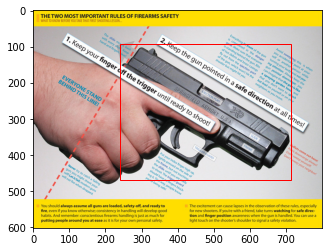

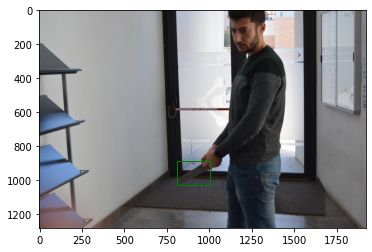

In [ ]:
# 이미지 + bounding box 출력

bbox = generate_target(annot_pistol_list[100])
plot_image(img_pistol_list[100], bbox)

kbox = generate_target(annot_knife_list[100])
plot_image(img_knife_list[100], kbox)

## **RetinaNet**

### **데이터 전처리**

In [ ]:
import os
import random
import numpy as np
import shutil

# 각 폴더안에 들어있는 리스트의 개수 출력
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/annotation/knife_xml')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/annotation/pistol_xml')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/knife')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images/pistol')))

2078
3000
2078
3000


In [ ]:
# 현재 디렉토리 변경 & 확인
os.chdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전')
print(os.getcwd())

/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Images 폴더 train / val 폴더로 분리
import splitfolders

splitfolders.ratio('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/Images',
                   output = '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_Images',
                   seed = 1337, ratio = (0.8, 0.2), group_prefix = None, move = False)

Copying files: 5078 files [03:32, 23.92 files/s]


In [ ]:
# annotation 폴더 train / val 폴더로 분리
import splitfolders

splitfolders.ratio('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/annotation',
                   output = '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_annotation',
                   seed = 1337, ratio = (0.8, 0.2), group_prefix = None, move = False)

Copying files: 5078 files [04:00, 21.10 files/s]


In [ ]:
# n_Images train/val 폴더 별 개수 확인
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_Images/train/knife')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_Images/train/pistol')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_Images/val/knife')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_Images/val/pistol')))

# n_annotation train/val 폴더 별 개수 확인
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_annotation/train/knife_xml')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_annotation/train/pistol_xml')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_annotation/val/knife_xml')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_annotation/val/pistol_xml')))

1662
2400
416
600
1662
2400
416
600


In [ ]:
import os
import shutil

# class별로 폴더 안나눠도 annotation에서 class구분할 수 있으므로 한개의 폴더로 합쳐줌
def folder_file_copy():
  file_dir = os.path.dirname('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/n_annotation/train/knife_xml')
  print(file_dir)
  file_cnt = 1
  for path, dirs, files in os.walk(file_dir):
    for file in files:
      file_path = os.path.join(path, file)
      print(f'file_cnt: {file_cnt}_{file_path}')
      file_cnt += 1
      dest_path = '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_annotation/' + file
      shutil.copy(file_path, dest_path)

folder_file_copy()

In [ ]:
# 최종 폴더별 이미지 개수 확인
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_annotation')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/test_Images')))
print(len(os.listdir('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/test_annotation')))

4062
4062
1016
1016


### **데이터셋 클래스 정의**

In [ ]:
# pre-loaded된 데이터 + 가지고 있는 데이터를 사용가능
# Dataset은 sample + label 저장
# DataLoader는 Dataset을 sample에 쉽게 접근할 수 있도록 순회가능한 객체(iterable)로 감쌈
from torch.utils.data import Dataset

# bounding box 좌표값 저장 및 반환
def generate_box(obj): 
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)
  
  return [xmin, ymin, xmax, ymax]


# class 별 bounding box labeling
def generate_label(obj):
    if obj.find('name').text == "knife":
        return 1

    return 0  # pistol인 경우


# generate_box & generate_label 실행 후 tensor 형태로 변환
def generate_target(file): 
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, "html.parser")
    objects = soup.find_all("object")

    num_objs = len(objects)

    boxes = []
    labels = []
    for i in objects:
      boxes.append(generate_box(i))
      labels.append(generate_label(i))

    boxes = torch.as_tensor(boxes, dtype=torch.float32) 
    labels = torch.as_tensor(labels, dtype=torch.int64) 
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    
    return target


# bounding box + image 출력
def plot_image_from_output(img, annotation):
  # pytorch는 [c,h,w]로 표현하지만 matplotlib에서는 [h,w,c]로 표현하므로 permute로 변경
  img = img.cpu().permute(1,2,0)
  rects = []
  fix, ax = plt.subplots(1)
  ax.imshow(img)

  for idx in range(len(annotation["boxes"])):
    xmin, ymin, xmax, ymax = annotation["boxes"][idx]

    # pistol인 경우
    if annotation['labels'][idx] == 0 :
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
    
    # knife인 경우
    else :
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

    rects.append(rect)
    ax.add_patch(rect)
    plt.show()

 # return img, rects


# weaponDataset class 정의
class weaponDataset(Dataset):
  def __init__(self, path, transform=None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform
      
  def __len__(self):
    return len(self.imgs)

  # __getitem__ 클래스의 인덱스에 접근할때마다 호출됨
  def __getitem__(self, idx):
    file_image = self.imgs[idx]  # 경로 없이 제목만 나옴
    file_label = self.imgs[idx][:-3] + 'xml' # 확장자를 xml로 만든 것
    img_path = os.path.join(self.path, file_image)
      
    if 'test' in self.path:
      label_path = os.path.join("/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/test_annotation/", file_label)
    else:
      label_path = os.path.join("/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_annotation/", file_label)

    img = Image.open(img_path).convert("RGB")
    target = generate_target(label_path)
    
    to_tensor = torchvision.transforms.ToTensor()

    if self.transform:
      img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
      target['boxes'] = torch.as_tensor(transform_target)

    # tensor로 변경
    img = to_tensor(img)

    return img, target

# 배치 단위 데이터의 변환 시 사용
def collate_fn(batch):
  return tuple(zip(*batch))

dataset = weaponDataset('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/')
test_dataset = weaponDataset('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/test_Images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

### **Augmentation 실행하는 Albumentations 클래스 정의**

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
# 이미지 사이즈 확인

from PIL import Image
 
image1 = Image.open('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/DSC_00011.JPG')
image1.show()
imag1_size = image1.size
print(imag1_size)

In [ ]:
! pip install albumentations==0.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached albumentations-0.5.2-py3-none-any.whl (72 kB)
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


In [ ]:
import albumentations
import albumentations.pytorch

class AlbumentationsDataset(Dataset):
  def __init__(self, path, transform=None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-3] + 'xml'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join("/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/test_annotation/", file_label)

    else:
      label_path = os.path.join("/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_annotation/", file_label)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    target = generate_target(label_path)

    start_t = time.time()
    if self.transform:
      augmented = self.transform(image = image)
      total_time = (time.time() - start_t)
      image = augmented['image']

    return image, target, total_time

In [ ]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(224,224),
    albumentations.pytorch.transforms.ToTensor()
])

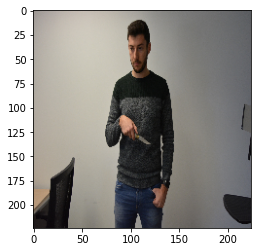

In [ ]:
albumentation_dataset = AlbumentationsDataset(
  path = '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/',
  transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[1]
plot_image_from_output(img, annot)

### **boundingbox 클래스 정의**

In [ ]:
class BboxAugmentationDataset(Dataset):
  def __init__(self, path, transform = None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-3] + 'xml'
    img_path = os.path.join(self.path, file_image) ### 여기 질문

    if 'test' in self.path:
      label_path = os.path.join('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/test_annotation/', file_label)
    
    else:
      label_path = os.path.join('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_annotation/', file_label)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    target = generate_target(label_path)

    if self.transform:
      transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
      image = transformed['image']
      target = {'boxes': transformed['bboxes'], 'labels': transformed['labels']}

    return image, target

###**Q**
왜 img_path는 test/train안나누고 os.path.join을 실행?

In [ ]:
bbox_transform = albumentations.Compose([
 albumentations.pytorch.transforms.ToTensor()],
 bbox_params = albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

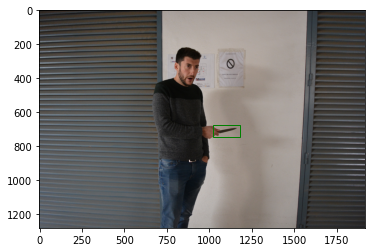

In [ ]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

In [ ]:
b = Image.open('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/DSC_00011.JPG')
b.size


# from PIL import Image
 
# image1 = Image.open('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/DSC_00011.JPG')
# image1.show()
# imag1_size = image1.size
# print(imag1_size)

(1920, 1281)

In [ ]:
from tqdm import tqdm
import pandas as pd
from collections import Counter
import cv2

# 클래스별로 객체 갯수 확인
def get_num_objects_for_each_class(dataset):

  total_labels = []

  for img, annot in tqdm(dataset, position = 0, leave = True):
    total_labels += [int(i) for i in annot['labels']]

  return Counter(total_labels) # counter클래스를 활용해 라벨별 개수를 세어 반환


train_data = BboxAugmentationDataset(
    path = '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/'
)

test_data = BboxAugmentationDataset(
    path = '/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/test_Images/'
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

# 한 이미지에 weapon이 두개 이상 있을 수 있으므로 객체 Counter 갯수는 이미지 갯수보다 많음
print('\n train 데이터에 있는 객체', train_objects)
print('\n test 데이터에 있는 객체', test_objects)

  1%|          | 41/4062 [00:04<08:08,  8.23it/s]


KeyboardInterrupt: ignored

### **모델 불러오기**

In [ ]:
import torchvision
import torch

torchvision.__version__

'0.14.1+cu116'

In [ ]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 2, pretrained=False, pretrained_backbone = True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to pass

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 3
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # gradient calculation이 필요한 params만 추출
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
  start = time.time()
  retina.train()

  i = 0    
  epoch_loss = 0
  for images, targets in data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = retina(images, targets) 

    losses = sum(loss for loss in loss_dict.values()) 

    i += 1

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    epoch_loss += losses 
  print(epoch_loss, f'time: {time.time() - start}')

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) time: 1217.3784501552582
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) time: 1166.6032013893127
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) time: 1164.592570066452


In [ ]:
# 모델 저장하기
torch.save(retina.state_dict(), f'/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/checkpoint/retina_{num_epochs}.pt')

In [ ]:
# 모델 불러오기
retina.load_state_dict(torch.load(f'/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/checkpoint/retina_{num_epochs}.pt'))

In [ ]:
# 예측
def make_prediction(model, img, threshold):
  model.eval()
  preds = model(img)
  for id in range(len(preds)):
    idx_list = []

    for idx, score in enumerate(preds[id]['scores']):
      if score > threshold:
        idx_list.append(idx)

    preds[id]['boxes'] = preds[id]['boxes'][idx_list]
    preds[id]['labels'] = preds[id]['labels'][idx_list]
    preds[id]['scores'] = preds[id]['scores'][idx_list]

  return preds

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader):
  im = list(img.to(device) for img in im)
  # annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

  for t in annot:
    labels += t['labels']

  # 예측된 모든 값은 preds_adj_all 변수에 저장
  with torch.no_grad():
    preds_adj = make_prediction(retina, im, 0.5)
    preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
    preds_adj_all.append(preds_adj)
    annot_all.append(annot)

100%|██████████| 127/127 [02:32<00:00,  1.20s/it]


In [ ]:
aa = sorted(glob.glob('/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/*'))
print(aa[0])
print(aa[0][:-3])
aaa = aa[0][:-3]+'xml'
path = "/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_annotation/"
ppath = os.path.join(path, aaa)
print(ppath)


/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/DSC_00011.JPG
/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/DSC_00011.
/content/drive/MyDrive/2023 ICT 융합 프로젝트 공모전/dataset/train_Images/DSC_00011.xml


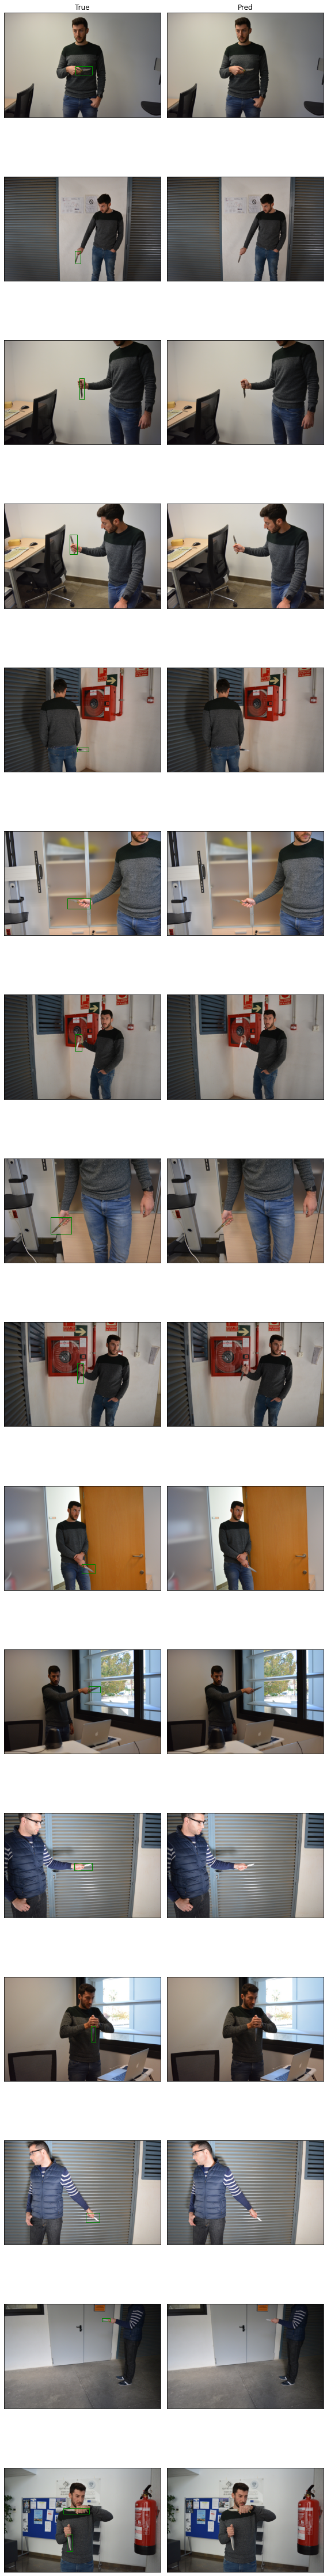

In [ ]:
# 실제 바운딩 박스와 예측한 바운딩 박스에 대한 시각화
nrows = 16
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
  pos = batch_i * 16 + 1
  for sample_i in range(len(im)):
    
    # 정답 bounding box + image 출력
    img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
    axes[(pos)//2, 1-((pos)%2)].imshow(img)   
    for rect in rects:
      axes[(pos)//2, 1-((pos)%2)].add_patch(rect)

    # 예측 bounding box + image 출력
    img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
    axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
    for rect in rects:
      axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

    pos += 2

  batch_i += 1
  
  if batch_i == 2:
    break

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
  ax.set_xticks([])
  ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
  ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()